# Image classification using CNNs in Keras

## Background
The ability to effectively differentiate a weed from a crop seedling can mean better crop yields and better stewardship of the environment. The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stages.

## Objective
The goal of the project is to create a classifier capable of determining a plant's species from a photo. The techniques to be used will be pre-processing of image data, visualisation of images, CNN building, and model evaluation.

## Data Description
The dataset is images of plant seedlings at various stages of growth. Each image has a filename that is a unique identifier. The dataset comprises 12 plant species.

(this notebook loaded to GitHub at https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-may20-pierssmith/tree/master/Week%2022%20-%20Project%20-%20Computer%20Vision)

#  
---
# 1 - Deliverables
---

# Deliverable 1: Import & load

## 1.1 Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

import itertools

## 1.2 Load dataset

In [3]:
drivePath = '/content/drive/My Drive/Learning/Colab Notebooks/UT AIML Course/Week 22 - PROJECT - Computer Vision/01 - Solution/'
sourceNumpyFilepath = drivePath + 'images.npy'
sourceLabelsFilepath = drivePath + 'Labels.csv'

sourceImageArray = np.load(sourceNumpyFilepath)
sourceLabels = pd.read_csv(sourceLabelsFilepath)

## 1.3 Print shape of data

In [4]:
sourceImageArray.shape

(4750, 128, 128, 3)

The source image array contains 4750 images, of size 128 x 128 pixels, with 3 channels (RGB format).

In [5]:
sourceLabels.shape

(4750, 1)

In [6]:
sourceLabels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

The source labels dataset contains 4750 labels. There is only 1 column - this contains a string which is the descriptive label for the image. The code provided in the project brief shows that the indexes correspond between the two datasets. There are 12 labels present (corresponds to the project brief).

## 1.4 Visualise images in dataset

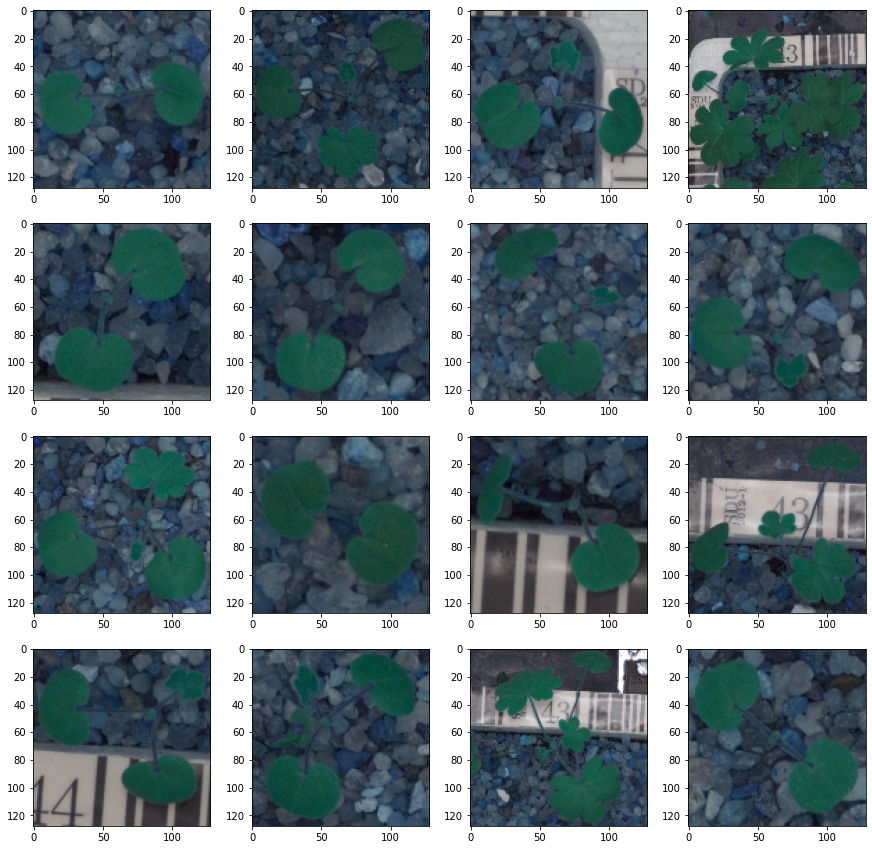

In [7]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4, 4, i + 1)  
    plt.imshow(sourceImageArray[i])

This visualisation of the first 16 images in the dataset shows the sample are all green seedlings shot against a background of blue/gray gravel, but in some images there are additional items that appear to be barcodes or labels in the background.

# Deliverable 2: Data pre-processing

## 2.1 Normalisation

As the source images are all RGB, the array can be normalised to improve the performance of the neural network by normalising the pixel values so they are all between 0 and 1, by dividing the values by 255. Although the method by which the source image library was converted to the numpy array is observed in the project brief, we can nevertheless establish that all the pixel values are in the correct range by examining the output of the min and max functions for the array.

In [8]:
print(sourceImageArray.min())
print(sourceImageArray.max())

0
255


In [9]:
normalisedImageArray = sourceImageArray.astype('float32') / 255

## 2.2 Gaussian blurring

In [10]:
for idx, img in enumerate(normalisedImageArray):
  normalisedImageArray[idx] = cv2.GaussianBlur(img, (5, 5), 0)

## 2.3 Post-processing visualisation

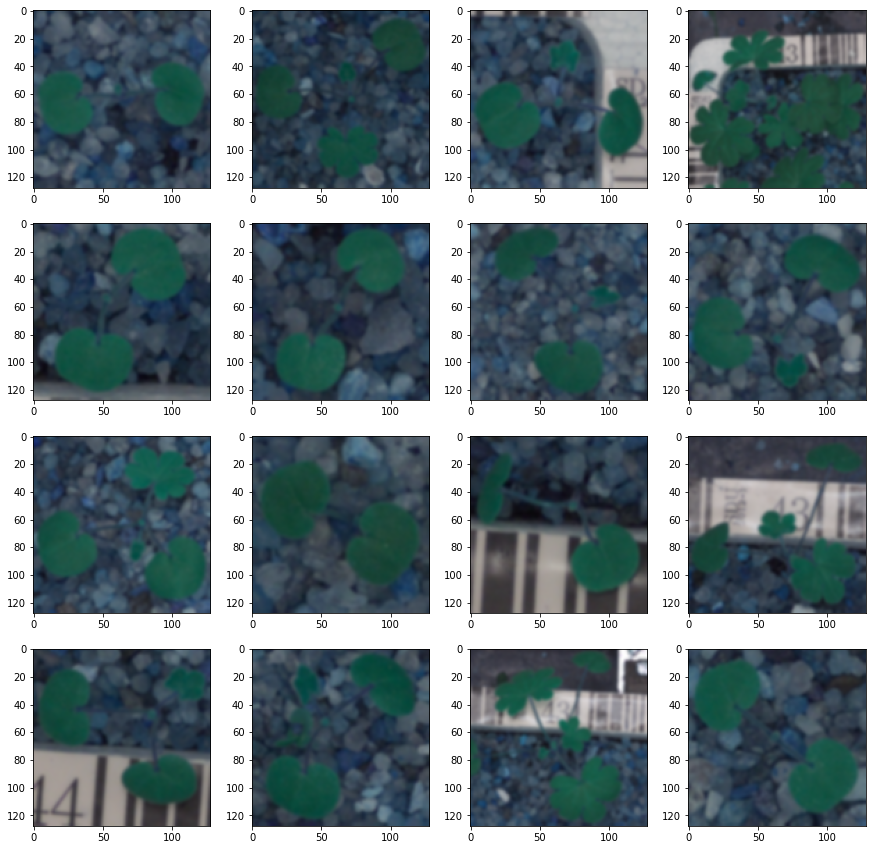

In [11]:
# repeat 1.4
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4, 4, i + 1)  
    plt.imshow(normalisedImageArray[i])

We can observe Gaussian blurring has been applied to the images in the normalised set.

# Deliverable 3: Data preparation

## 3.1 Convert labels to one-hot vectors

In [12]:
enc = LabelBinarizer()
encodedLabels = enc.fit_transform(sourceLabels)

## 3.2 Print first encoded label

In [13]:
encodedLabels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

## 3.3 Split dataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(normalisedImageArray, encodedLabels, train_size=0.70, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, train_size=0.50, random_state=0)

The data is split into three sets - training and validation for the model building, and test for evaluation. The splits are 70% to training, and the remaining 30% divided evenly into validation and test.

## 3.4 Check shape

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_validation.shape)
print(y_validation.shape)

(3325, 128, 128, 3)
(3325, 12)
(713, 128, 128, 3)
(713, 12)
(712, 128, 128, 3)
(712, 12)


Note that image data does not require reshaping for Keras. Keras expects the image data to be in the form (number, height, width, channels), and as per the shape outputs above for all three sets (training, test, and validation) the data has not been flattened and is already in the correct shape.

We also observe that the training, validation, and test splits are correct.

# Deliverable 4: Building CNN

## 4.1 Define layers

This model architecture is based on architectures observed in this course that performed well for colour image classification in multiple classes. This is four convolutional layers, each followed by batch normalisation, pooling, and dropout, a fully connected layer with 256 units, and a fully connected output layer with the 12 classes required for species prediction using the softmax activation function.

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

## 4.2 Set optimiser and loss functions

As per the project brief, using the Adam optimiser and categorical cross-entropy for loss. Also defining here a ModelCheckpoint callback, so the best weights are saved where the validation loss is lowest.

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

checkpointPath = drivePath + 'checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5'
model_checkpoint =  ModelCheckpoint(checkpointPath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

# Deliverable 5: Fit and evaluate

## 5.1 Fit and evaluate model

In [18]:
batch_size = 32
epochs = 200

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_validation, y_validation),
                    shuffle=True,
                    verbose=1,
                    callbacks=[model_checkpoint])

Epoch 1/200
104/104 [==============================] - ETA: 0s - loss: 3.5444 - accuracy: 0.1759
Epoch 00001: val_loss improved from inf to 2.52153, saving model to /content/drive/My Drive/Learning/Colab Notebooks/UT AIML Course/Week 22 - PROJECT - Computer Vision/01 - Solution/checkpoint_01_loss2.5215.h5
104/104 [==============================] - 3s 33ms/step - loss: 3.5444 - accuracy: 0.1759 - val_loss: 2.5215 - val_accuracy: 0.0969
Epoch 2/200
104/104 [==============================] - ETA: 0s - loss: 1.9014 - accuracy: 0.3420
Epoch 00002: val_loss did not improve from 2.52153
104/104 [==============================] - 3s 28ms/step - loss: 1.9014 - accuracy: 0.3420 - val_loss: 2.5430 - val_accuracy: 0.1348
Epoch 3/200
102/104 [============================>.] - ETA: 0s - loss: 1.6424 - accuracy: 0.4161
Epoch 00003: val_loss did not improve from 2.52153
104/104 [==============================] - 3s 28ms/step - loss: 1.6405 - accuracy: 0.4171 - val_loss: 2.9105 - val_accuracy: 0.1348
E

In [19]:
bestCheckpointPath = '/content/drive/My Drive/Learning/Colab Notebooks/UT AIML Course/Week 22 - PROJECT - Computer Vision/01 - Solution/checkpoint_195_loss0.2111.h5'
model.load_weights(bestCheckpointPath)

## 5.2 Print confusion matrix

In [20]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 13ms/step - loss: 0.2399 - accuracy: 0.9229
Test loss: 0.2399049699306488
Test accuracy: 0.9228611588478088


On the unseen test data (X_test), the model achieves an accurancy of 92.28%, which is excellent.

In [21]:
# Define a function to draw a confusion matrix with the class label strings

def drawConfusionMatrix(cm, classes):
    
    plt.figure(figsize=(12,12))
    plt.title('Seedling Prediction - Confusion Matrix')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.RdYlGn)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="black")
                 
    plt.tight_layout()
    plt.ylabel('Actual Species')
    plt.xlabel('Predicted Species')

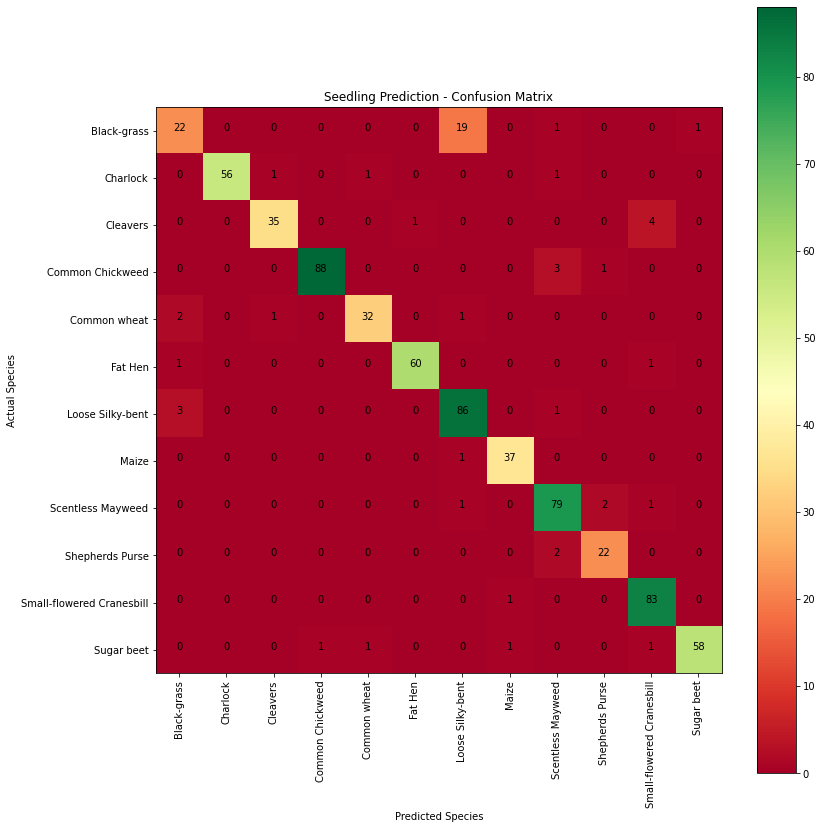

In [22]:
y_pred = model.predict(X_test)
predictedClasses = np.argmax(y_pred, axis = 1)
actualClasses = np.argmax(y_test, axis = 1)

cm = confusion_matrix(actualClasses, predictedClasses)
drawConfusionMatrix(cm, classes = enc.classes_) 

The confusion matrix shows the model is performing very well. Other than 19 images that were predicted as "Loose Silky-bent" but were actually "Black-grass", there are very few off-diagonal results.

# Deliverable 6: Visualise predictions

The project brief calls for predictions to be visualised for a sample of the images from the test set - indexes 2, 3, 33, 36 and 59. These are visualised below, with the predicted and actual labels.

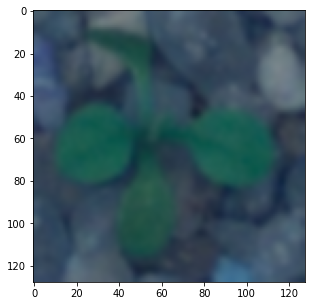

Predicted Species: ['Shepherds Purse']
Actual Species: ['Shepherds Purse']


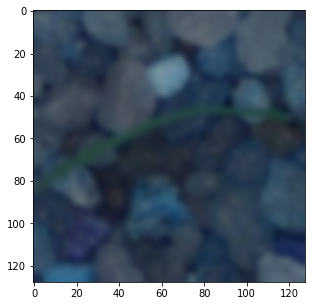

Predicted Species: ['Loose Silky-bent']
Actual Species: ['Loose Silky-bent']


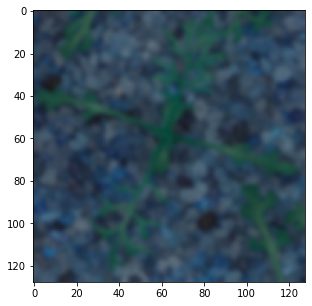

Predicted Species: ['Scentless Mayweed']
Actual Species: ['Scentless Mayweed']


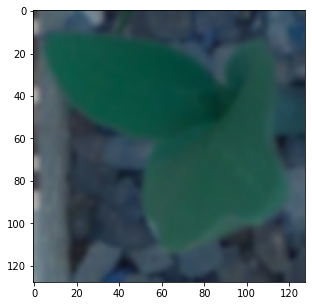

Predicted Species: ['Maize']
Actual Species: ['Maize']


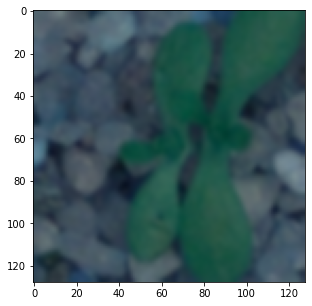

Predicted Species: ['Scentless Mayweed']
Actual Species: ['Scentless Mayweed']


In [23]:
samplePredictionIndexes = [2, 3, 33, 36, 59]

for i in samplePredictionIndexes:
  y_pred_sample = model.predict(X_test[i].reshape(1, 128, 128, 3))
  predictedClass_sample = np.argmax(y_pred_sample, axis = 1)
  actualClass_sample = y_test[i].nonzero()[0]
  plt.figure(figsize=(5,5))
  plt.imshow(X_test[i])
  plt.show()
  print('Predicted Species:', enc.classes_[predictedClass_sample])
  print('Actual Species:', enc.classes_[actualClass_sample])


All the visualised samples from the unseen test data were correctly predicted.